# Log AutoGen Group Chat

[AutoGen](https://microsoft.github.io/autogen/0.2/) is an innovative open-source framework designed to streamline the development of AI agents capable of cooperative task-solving. Key features include support for large language models (LLMs), agent conversation capabilities, and both autonomous and human-assisted workflows. AutoGen is essential for building next-generation LLM applications, simplifying the orchestration and optimization of complex multi-agent conversations and boosting the performance of LLMs.

The Group Chat feature of AutoGen allows developers to customize agent interactions by defining conversation patterns and workflows. This customization is crucial as it enables precise control over the dialogue dynamics among agents, making development less cumbersome and more efficient. Tracking these interactions is vital to refining the agent's performance and ensuring the successful deployment of sophisticated multi-agent systems.

This tutorial demonstrates how we can build multi-agent system with AutoGen Group Chat and trace them with [Weave](../../introduction.md).


## Installing the Dependencies

We need the following libraries for this tutorial:
- [AutoGen](https://microsoft.github.io/autogen/0.2/) to create multi-agent system.
- [Weave](../../introduction.md) to track our LLM workflow and evaluate our prompting strategies.


In [ ]:
!pip install -qU autogen-agentchat~=0.2 weave wandb

In [ ]:
import os
import autogen

from google.colab import userdata

import weave
import wandb

We set `WANDB_API_KEY` in our env so that we may easily login with wandb.login() (this should be given to the colab as a secret).
We set the project in W&B we want to log this into in `name_of_wandb_project`.

**NOTE**: `name_of_wandb_project` may also be in the format of `{team_name}/{project_name}` to specify a team to log the traces into.
We then fetch a weave client by calling weave.init()

Since we'll be using [OpenAI API](https://openai.com/index/openai-api/), we will also need an OpenAI API key. You can [sign up](https://platform.openai.com/signup) on the OpenAI platform to get your own API key. (this should be given to the colab as a secret too.)


In [ ]:
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

wandb.login()
name_of_wandb_project = "autogen_group_chat"
weave.init(name_of_wandb_project)

## Group Chat set up
In GroupChat, we can customize the speaker selection by passing a function to the GroupChat object.
The use case we will tackle is a survey of AI safety. Firstly, we define the following agents.

* Admin: Human in the loop to approve or terminate the process.
* Planner: Give a plan.
* Engineer: Retrieve papers from the internet by writing code.
* Executor: Execute the code.
* Scientist: Read the papers and get insights from them.
* Critic: Double check plan, claims, and code from other agents and provide feedback.

In [ ]:
gpt4o_config = {
    "cache_seed": 0,
    "temperature": 0,
    "config_list": [{"model": "gpt-4o", "api_key": os.environ["OPENAI_API_KEY"]}],
    "timeout": 120,
}

In [ ]:
user_proxy = autogen.UserProxyAgent(
    name="Admin",
    system_message="A human admin. Interact with the planner to discuss the plan. Plan execution needs to be approved by this admin.",
    code_execution_config=False,
)
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=gpt4o_config,
    system_message="""Engineer. You follow an approved plan. You write python/shell code to solve tasks. Wrap the code in a code block that specifies the script type. The user can't modify your code. So do not suggest incomplete code which requires others to modify. Don't use a code block if it's not intended to be executed by the executor.
Don't include multiple code blocks in one response. Do not ask others to copy and paste the result. Check the execution result returned by the executor.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
""",
)
scientist = autogen.AssistantAgent(
    name="Scientist",
    llm_config=gpt4o_config,
    system_message="""Scientist. You follow an approved plan. You are able to categorize papers after seeing their abstracts printed. You don't write code.""",
)
planner = autogen.AssistantAgent(
    name="Planner",
    system_message="""Planner. Suggest a plan. Revise the plan based on feedback from admin and critic, until admin approval.
The plan may involve an engineer who can write code and a scientist who doesn't write code.
Explain the plan first. Be clear which step is performed by an engineer, and which step is performed by a scientist.
""",
    llm_config=gpt4o_config,
)
executor = autogen.UserProxyAgent(
    name="Executor",
    system_message="Executor. Execute the code written by the engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "paper",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)
critic = autogen.AssistantAgent(
    name="Critic",
    system_message="Critic. Double check plan, claims, and code from other agents and provide feedback. Check whether the plan includes adding verifiable info such as source URL.",
    llm_config=gpt4o_config,
)

We will then define a Group Chat Manager.

In [ ]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, scientist, planner, executor, critic], messages=[], max_round=50
)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4o_config)

We will then define a Group Chat Manager.

In [ ]:
@weave.op()
def initiate_chat(user_proxy ,message):
    return user_proxy.initiate_chat(
        manager,
        message=message,
    )

## Tacking of Group Chat using Weave

Weave is currently integrated with OpenAI, and including weave.init at the start of our code lets us automatically capture traces for the openai python library. Check out the Weave integration [docs for OpenAI](https://weave-docs.wandb.ai/guides/integrations/openai) to learn more.
In this use case, we use gpt-4o in each agent, we can automatically track the conversations between agents.

Since integration with OpenAI alone does not allow conversations to be aggregated on Weave's traces UI, we will develope a function to initiate chats. Adding the `@weave.op` decorator on top of `initiate_chat` function enables conversations to be tracked as a trace tree on Weave.

In [ ]:
message = """
find papers on AI safety from arxiv in the past three months, pick up three important points
"""

initiate_chat(user_proxy ,message)

When we click on the URL for Weave, we can see that the execution is being traced as follows.  On the Traces page, we can check the input and output.

Weave provides integration with OpenAI's API, which allows costs to be automatically calculated. So, we can confirm cost and latency are also displayed on the far right.

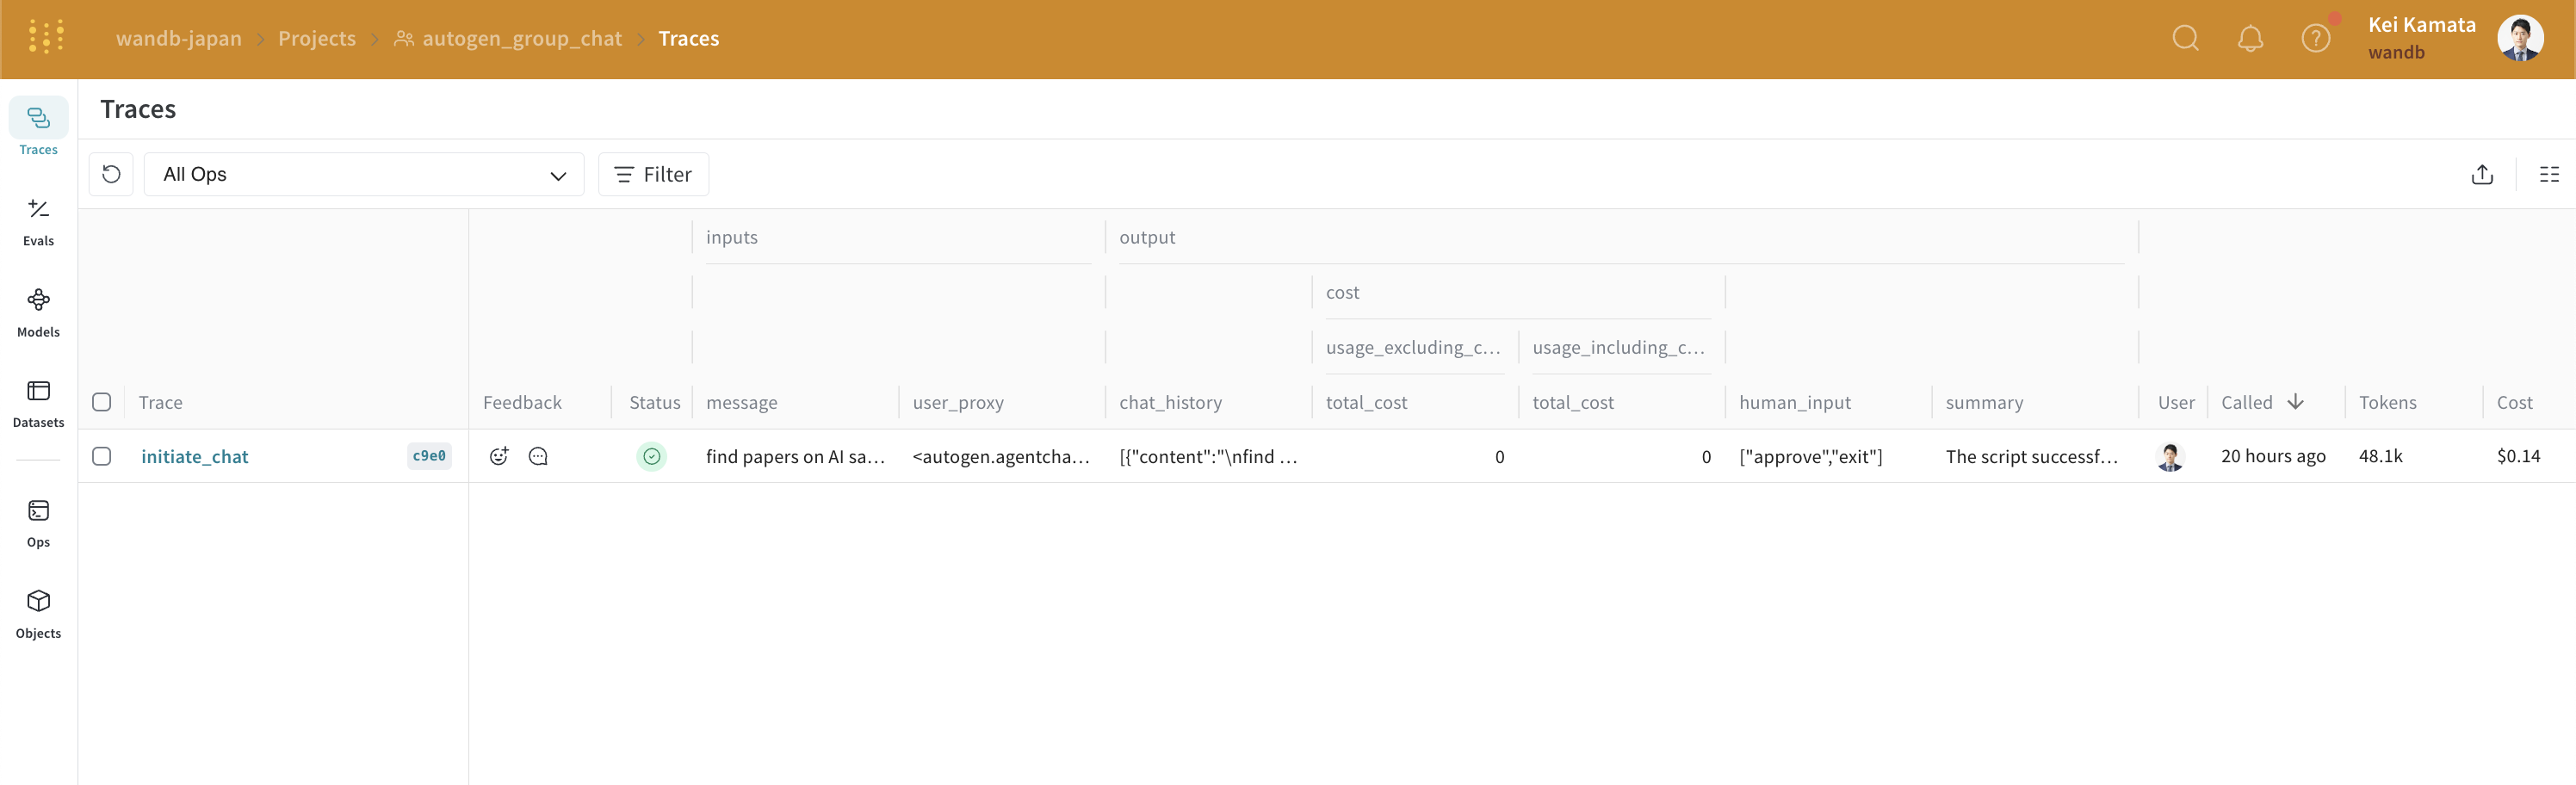

By clicking on a line, we can see the intermediate processes that were executed within the group chat. This trace allows us to understand what inputs each agent receives and what functions they execute.

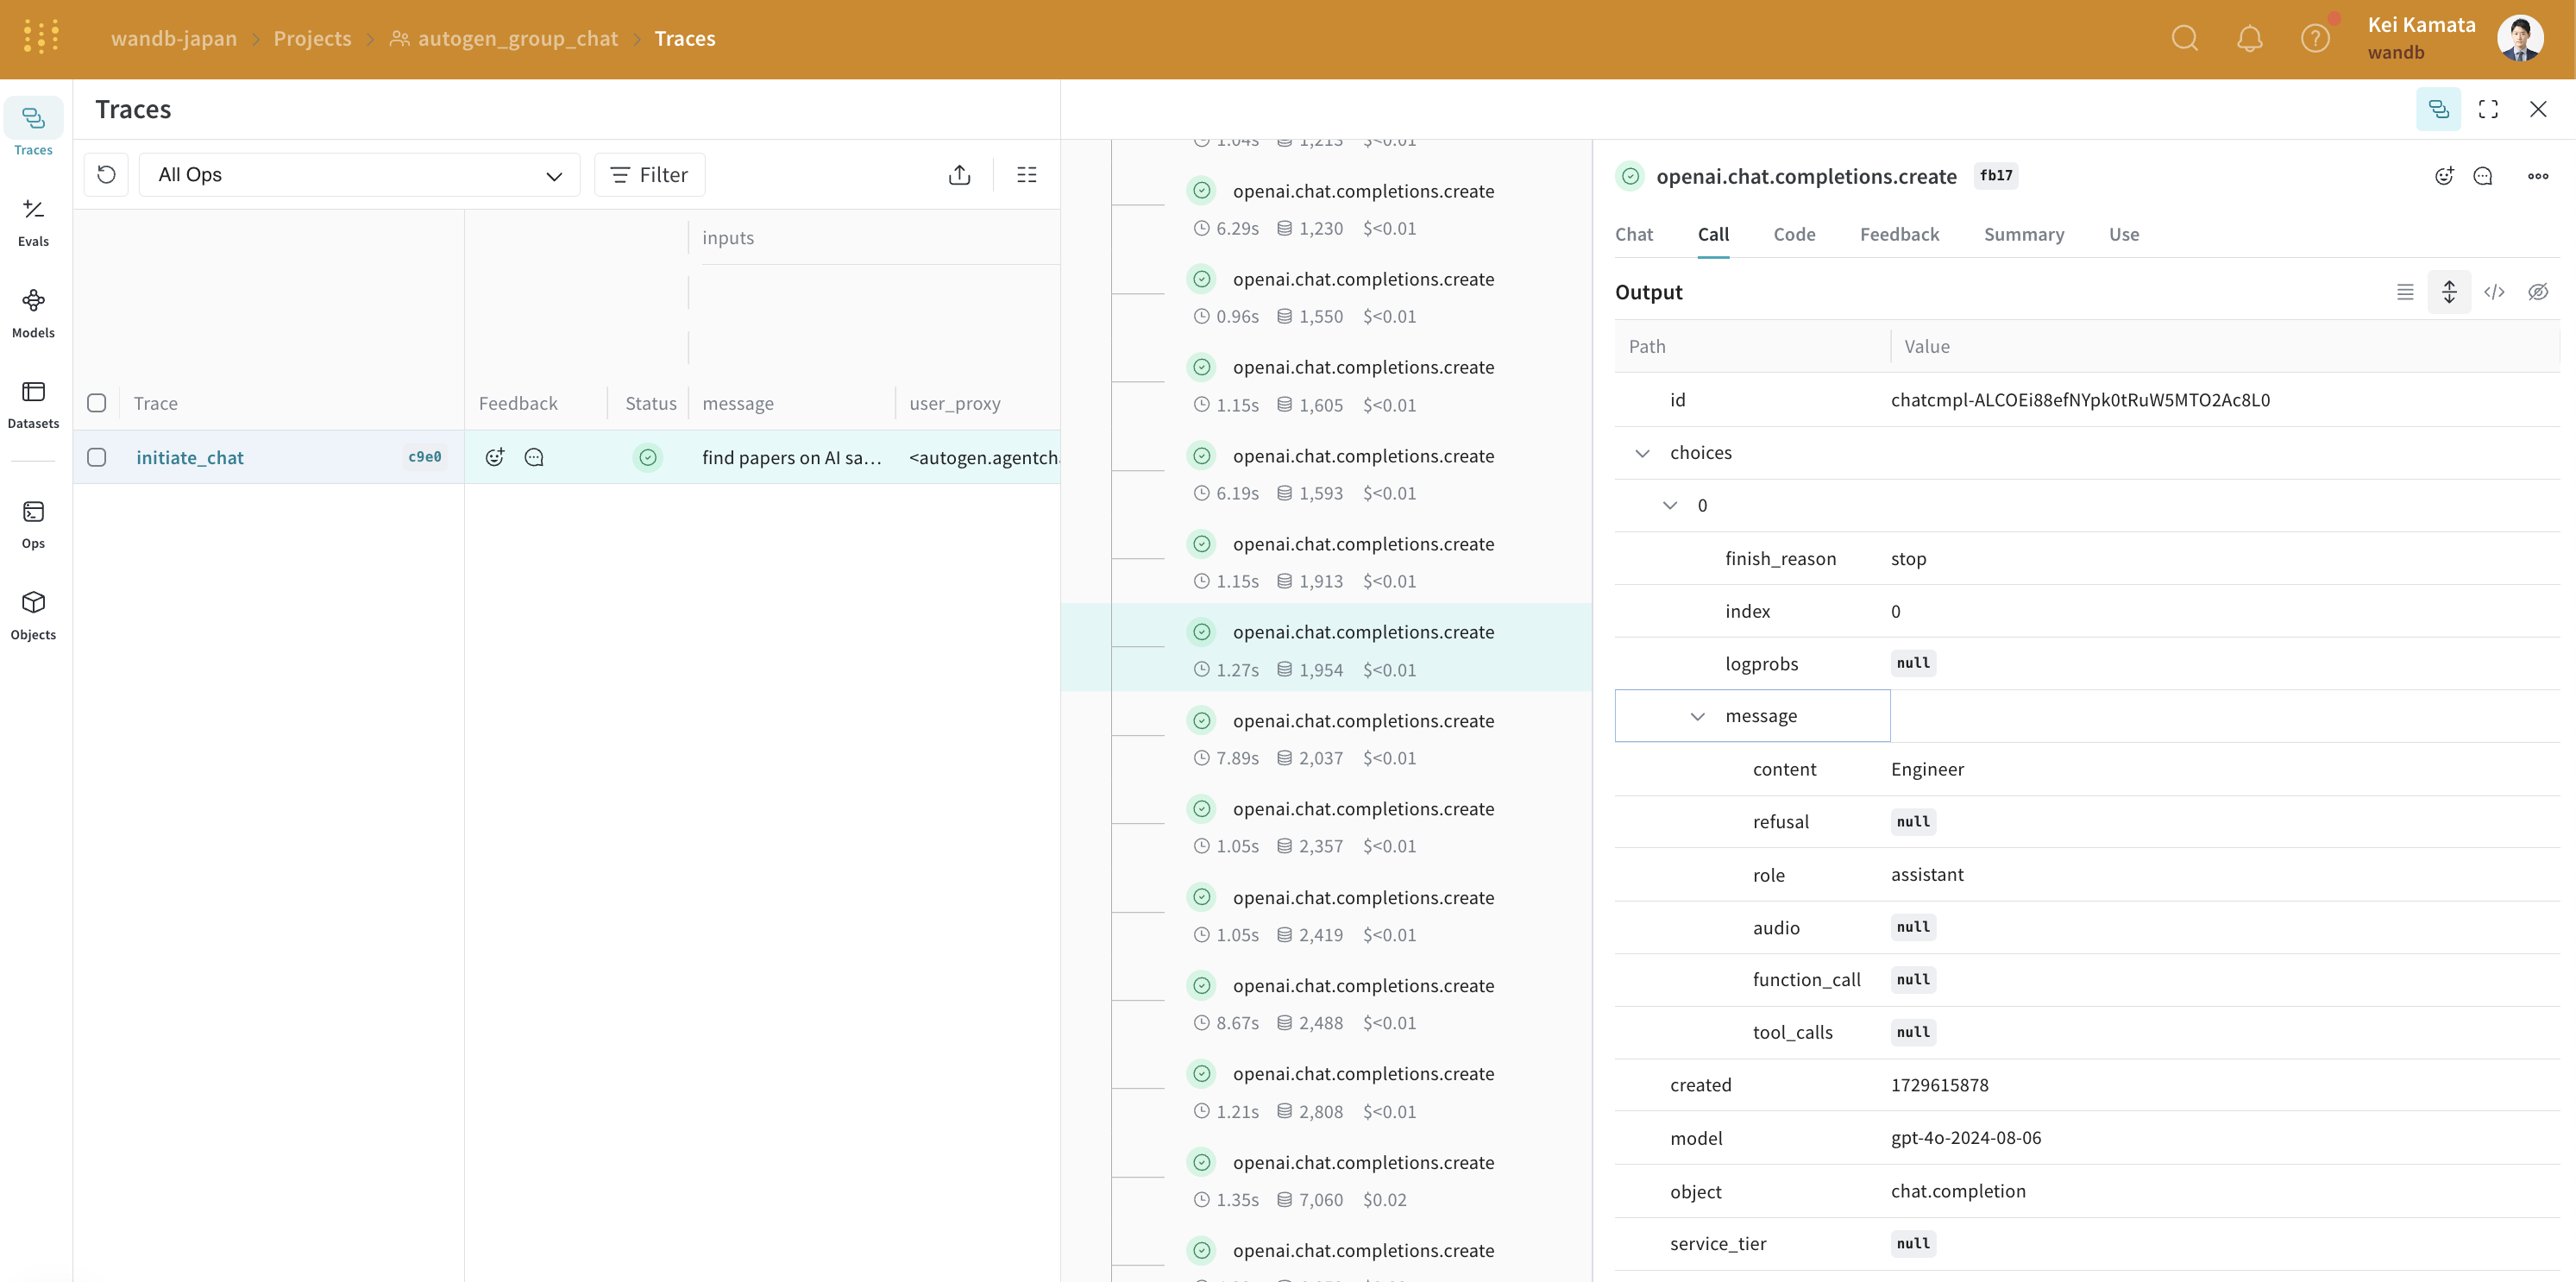

Additionally, Weave can display the chat in a clear and comprehensible manner, making it easy to review the internal conversations. By using weave, we can track a multi-agent system built with AutoGen in a nice way without adding lots of weave codes.

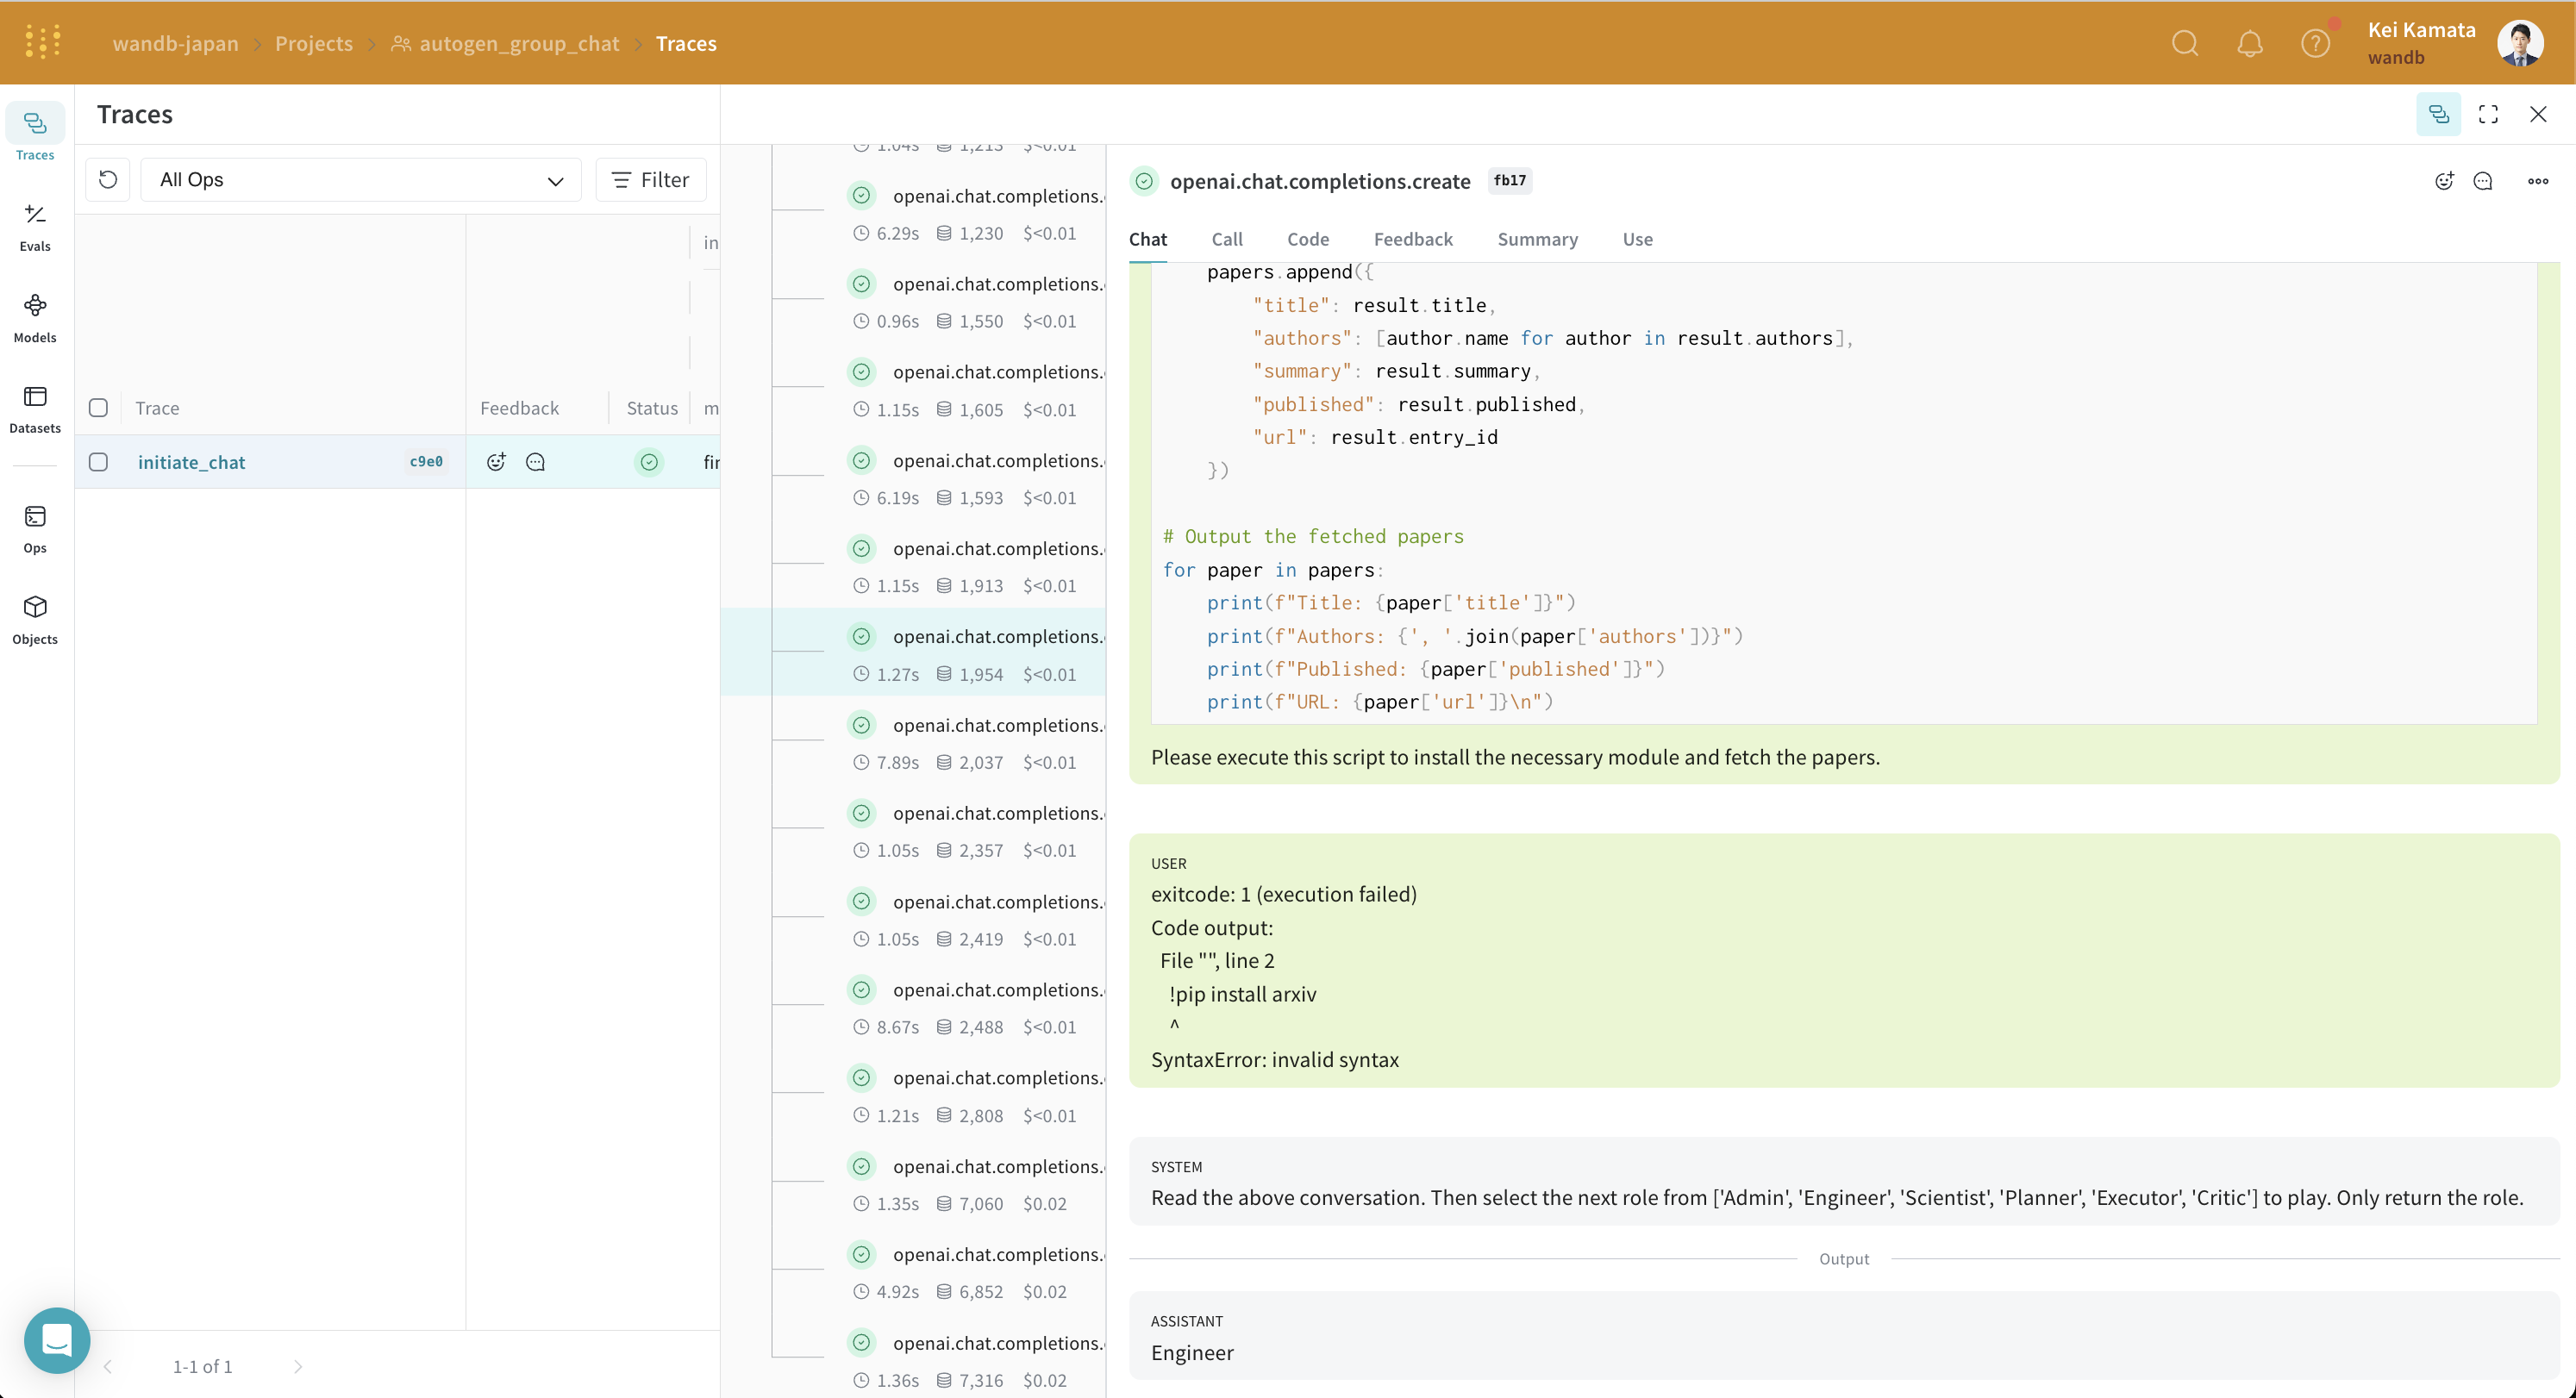

## Conclusion
In this tutorial, we learned how to conveniently develop a multi-agent system using AutoGen and Weave for tracking inputs, final outputs, and intermediate output formats.
We've shown to:
* Trace the agents in AugoGen automatically with Weave by utilizing the integration of OpenAI
* Wrap the conversation with a `@weave.op` decorator
* Confirm the intermediate process and chat in Weave UI.

For more information on Weave and its capabilities, check out the [Weave documentation](https://weave-docs.wandb.ai/).